# IQS Data Explorer Example

This notebook demonstrates how to use the unified configuration system with the Text2Cypher workflow to analyze Honda vehicle customer feedback data.

In [1]:
import sys
import os

# Add the project root to Python path
sys.path.append("../..")

In [2]:
from dotenv import load_dotenv
from langchain_neo4j import Neo4jGraph
from langchain_openai import ChatOpenAI

from neo4j_text2cypher.retrievers.cypher_examples import UnifiedConfigCypherExampleRetriever
from neo4j_text2cypher.utils.config import UnifiedAppConfigLoader
from neo4j_text2cypher.workflows.neo4j_text2cypher_workflow import create_neo4j_text2cypher_workflow

In [3]:
# Load environment variables
load_dotenv()

True

## Initialize Components

Load configuration and set up the Neo4j graph connection, LLM, and unified Cypher example retriever.

In [5]:
# Load unified configuration
config_path = "app-config.yml"
config_loader = UnifiedAppConfigLoader(config_path)

# Initialize Neo4j graph connection (uses environment variables)
graph = Neo4jGraph(enhanced_schema=True)
print("Connected to Neo4j")
print(f"Schema: {graph.schema[:500]}...")  # Print first 500 chars of schema

Connected to Neo4j
Schema: Node properties:
- **Customer**
  - `id`: STRING Example: "9A79438B"
  - `ageBucket`: STRING Example: ">=70"
  - `gender`: STRING Available options: ['Male', 'Female', '']
- **Category**
  - `id`: STRING Available options: ['Exterior', 'Driving Experience', 'Features/Controls/Displays (FCD)', 'Driving Assistance', 'Infotainment', 'Seats', 'Climate', 'Interior', 'Powertrain']
- **Problem**
  - `id`: STRING Example: "EXT01"
  - `problem`: STRING Example: "EXT01: Doors - Hard to open/close"
- **Que...


In [6]:
# Initialize LLM
llm = ChatOpenAI(model="gpt-4o", temperature=0)
print("LLM initialized")

LLM initialized


In [8]:
# Initialize unified Cypher example retriever
cypher_example_retriever = UnifiedConfigCypherExampleRetriever(config_path=config_path)

# Get Streamlit configuration for scope description
streamlit_config = config_loader.get_streamlit_config()
print(f"Loaded {len(config_loader.get_example_queries())} example queries from: {config_path}")
print(f"App: {streamlit_config.title}")
print(f"Scope: {streamlit_config.scope_description[:100]}...")

Loaded 16 example queries from: app-config.yml
App: IQS Data Explorer
Scope: This application may answer questions related to customer feedback on Honda vehicles....


## Create the Workflow

Set up the text2cypher workflow using the unified configuration system.

In [9]:
# Create the workflow using unified configuration
agent = create_neo4j_text2cypher_workflow(
    llm=llm,
    graph=graph,
    scope_description=streamlit_config.scope_description,
    cypher_example_retriever=cypher_example_retriever,
    llm_cypher_validation=False,
    max_attempts=3,
    attempt_cypher_execution_on_final_attempt=False,
    enable_final_answer_validation=True
)

print("Text2Cypher workflow created successfully!")
print(f"Configuration loaded from: {config_path}")

Text2Cypher workflow created successfully!
Configuration loaded from: app-config.yml


## Visualize the Workflow

Display the workflow graph to understand the execution flow.

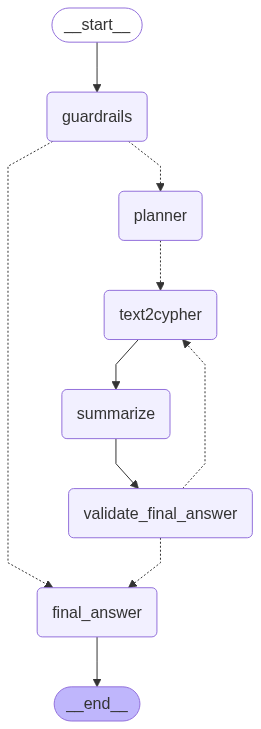

In [10]:
from IPython.display import Image, display

try:
    # Display the workflow graph
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Workflow structure:")
    print("Input → Guardrails → Planner → Text2Cypher → Summarize → Validate → Final Answer")

Visualization below with more detail on the Text2Cypher component

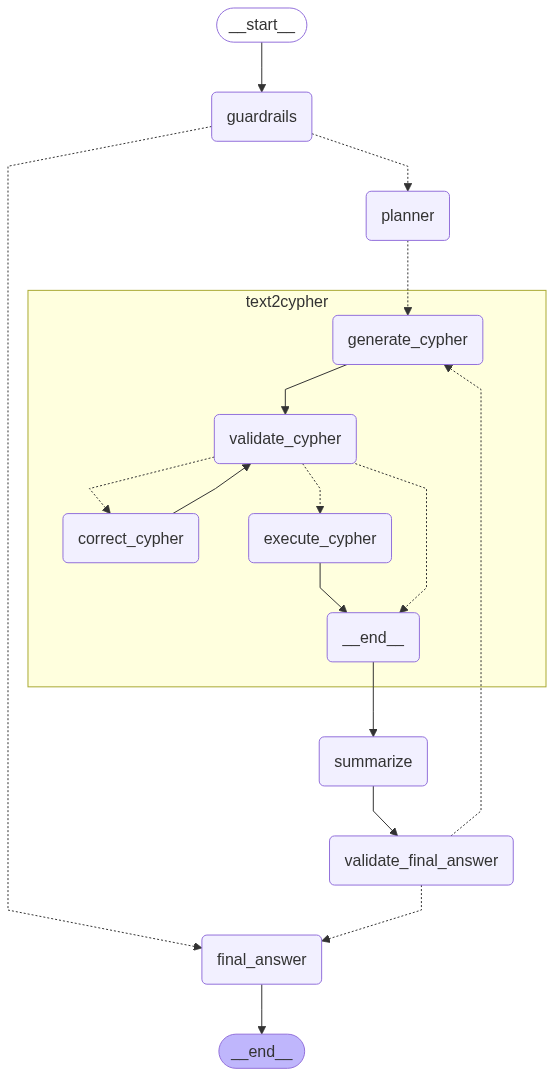

In [11]:
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

## Example Usage

Run some example questions from the configuration through the workflow.

In [12]:
# Use the first example question from configuration
question = streamlit_config.example_questions[0]
print(f"Testing with example question: {question}")

response = await agent.ainvoke({
    "question": question,
    "data": [],
    "history": []
})

print(f"Question: {response.get('question')}")
print(f"\nAnswer: {response.get('answer')}")

Testing with example question: How many vehicles are there?
Question: How many vehicles are there?

Answer: There are 12 vehicles.


## Examine the Results

Look at the generated Cypher queries and execution steps.

In [13]:
# Display the execution steps
print("Execution Steps:")
for step in response.get("steps", []):
    print(f"  - {step}")

Execution Steps:
  - guardrails
  - planner
  - ['generate_cypher', 'validate_cypher', 'execute_cypher']
  - summarize
  - validate_final_answer
  - final_answer


In [13]:
# Display generated Cypher queries and results
cyphers = response.get("cyphers", [])
print(f"\nGenerated {len(cyphers)} Cypher queries:")

for i, cypher_result in enumerate(cyphers):
    print(f"\n--- Query {i+1} ---")
    print(f"Task: {cypher_result.get('task')}")
    print(f"Cypher: {cypher_result.get('statement')}")
    
    records = cypher_result.get('records', [])
    print(f"Results: {len(records)} records")
    
    # Show first few records
    for j, record in enumerate(records[:3]):
        print(f"  Record {j+1}: {record}")
    
    if len(records) > 3:
        print(f"  ... and {len(records) - 3} more records")


Generated 1 Cypher queries:

--- Query 1 ---
Task: How many vehicles are there?
Cypher: MATCH (v:Vehicle)
RETURN COUNT(v) AS totalVehicles
Results: 1 records
  Record 1: {'totalVehicles': 12}


## Try Your Own Questions

You can also try any of the example questions from the configuration or create your own.

In [14]:
# Show available example questions
print("Available example questions from configuration:")
for i, q in enumerate(streamlit_config.example_questions[:5], 1):
    print(f"{i}. {q}")

# Try one of the Honda-specific questions
my_question = streamlit_config.example_questions[1]  # Use second example question
print(f"\nTesting question: {my_question}")

my_response = await agent.ainvoke({
    "question": my_question,
    "data": [],
    "history": []
})

print(f"\nAnswer: {my_response.get('answer')}")

# Show Cypher queries
my_cyphers = my_response.get("cyphers", [])
for cypher_result in my_cyphers:
    print(f"\nCypher: {cypher_result.get('statement')}")
    records = cypher_result.get('records', [])
    if records:
        print(f"Result: {records[0] if records else 'No results'}")

Available example questions from configuration:
1. How many vehicles are there?
2. Summarize the responses under fcd10 for honda pilot. What is the men to women proportion for these responses and what is the problem for fcd10?
3. What are the top 5 most severe problems for women aged 30-34 for all Acura models?
4. Please summarize the verbatims for 2023 RDX for question 010 Trunk/TG Touch-Free Sensor DTU and create categories for the problems. As an output, I want the summary, corresponding categories and their verbatims
5. What are the top 5 problems about seats for each age buckets for men over the age of 53?

Testing question: Summarize the responses under fcd10 for honda pilot. What is the men to women proportion for these responses and what is the problem for fcd10?

Answer: - **Summary of Responses under FCD10 for Honda Pilot:**
  - Users report that the touch system to lock and unlock doors is unreliable, often requiring multiple attempts or manual intervention.
  - Some users e